In [1]:
import os
import utilities as rocku
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import timeit
from pystackreg import StackReg
from PIL import Image
from tqdm import tqdm
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


In [2]:
# need to change
ipts="33799"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
scan_type = 'processed_data/angel'
# scan_type = 'analysis'
# scan_type = 'analysis'
####################################
##################################
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/" + scan_type #+ "/2024_09_18_PTFE_HDPE_PET_15umG2"
folder_list = os.listdir(scan_loc)
folder_list.sort()
folder_list

['2025_02_27_BotL1',
 '2025_02_27_BotL2',
 '2025_02_27_BotL3',
 '2025_02_27_BotL4',
 '2025_02_27_TopL1',
 '2025_02_27_TopL2',
 '2025_02_27_TopL3',
 '2025_02_27_TopL4']

In [74]:
sample_name = "2025_02_27_TopL4"
# distance_to_G2_cm = 1.6
distance_to_G2_cm = 2
reverse_sort = False
reverse_motor = False
######################
wavelen_ang = 2.5
period_um = 56.5
# period_um = 15
name_pattern_std = ["TI_ACL", "DFI_ACL", "DPC_ACL"]
name_pattern = ["TI_ACL", "DFI_ACL", "DPC_ACL", "AI_ACL", "DFI_over_AI_ACL"]
ref_name = name_pattern[0]
######################
######################
######################
scan_dir = os.path.join(scan_loc, sample_name)
fname_list = os.listdir(scan_dir)
fname_list.sort()
fname_dict = {}
for e_pa in name_pattern:
    _fname_list = rocku.filter_list(fname_list, e_pa)
    _fname_list.sort(reverse=reverse_sort)
    fname_dict[e_pa] = _fname_list
pos_list = []
for each in fname_dict[name_pattern[0]]:
    _n = each.split('.')[0]
    _num = int(_n.split('_')[-1])
    pos_list.append(_num)
######################
fname_dict_out = {}
acl_list = []
pos_max = max(pos_list)
pos_min = min(pos_list)
for e_pos in pos_list:
    if reverse_motor:
        _acl_nm = int(1000*wavelen_ang*((pos_max-e_pos)/10 + distance_to_G2_cm)/period_um)
    else:
        _acl_nm = int(1000*wavelen_ang*((e_pos-pos_min)/10 + distance_to_G2_cm)/period_um)
    acl_list.append("{:04d}".format(_acl_nm) + "nm")
for e_pa in name_pattern:
    _fname_list_out = []
    for e_acl in acl_list:
        _fname_list_out.append("_".join([e_pa, e_acl]))
    fname_dict_out[e_pa] = _fname_list_out
for ea_pa in name_pattern:
    print(ea_pa)
    for m, ea_file in enumerate(fname_dict[ea_pa]):
        print("'{}' converted to '{}'".format(ea_file, fname_dict_out[ea_pa][m]))

TI_ACL
'TI_ACL_075.fits' converted to 'TI_ACL_0088nm'
'TI_ACL_090.fits' converted to 'TI_ACL_0154nm'
DFI_ACL
'DFI_ACL_075.fits' converted to 'DFI_ACL_0088nm'
'DFI_ACL_090.fits' converted to 'DFI_ACL_0154nm'
DPC_ACL
'DPC_ACL_075.fits' converted to 'DPC_ACL_0088nm'
'DPC_ACL_090.fits' converted to 'DPC_ACL_0154nm'
AI_ACL
DFI_over_AI_ACL


In [75]:
unreg_dict = {}
for e_pa in name_pattern_std:
    print("Loading {} ...".format(e_pa))
    _img_stack = rocku.read_img_stack(scan_dir, fname_dict[e_pa], flipud=True)
    unreg_dict[e_pa] = _img_stack.astype(np.float32)

Loading TI_ACL ...


2it [00:00, 11.24it/s]


Loading DFI_ACL ...


2it [00:00, 12.52it/s]


Loading DPC_ACL ...


2it [00:00, 12.42it/s]


Text(0.5, 1.0, 'last image')

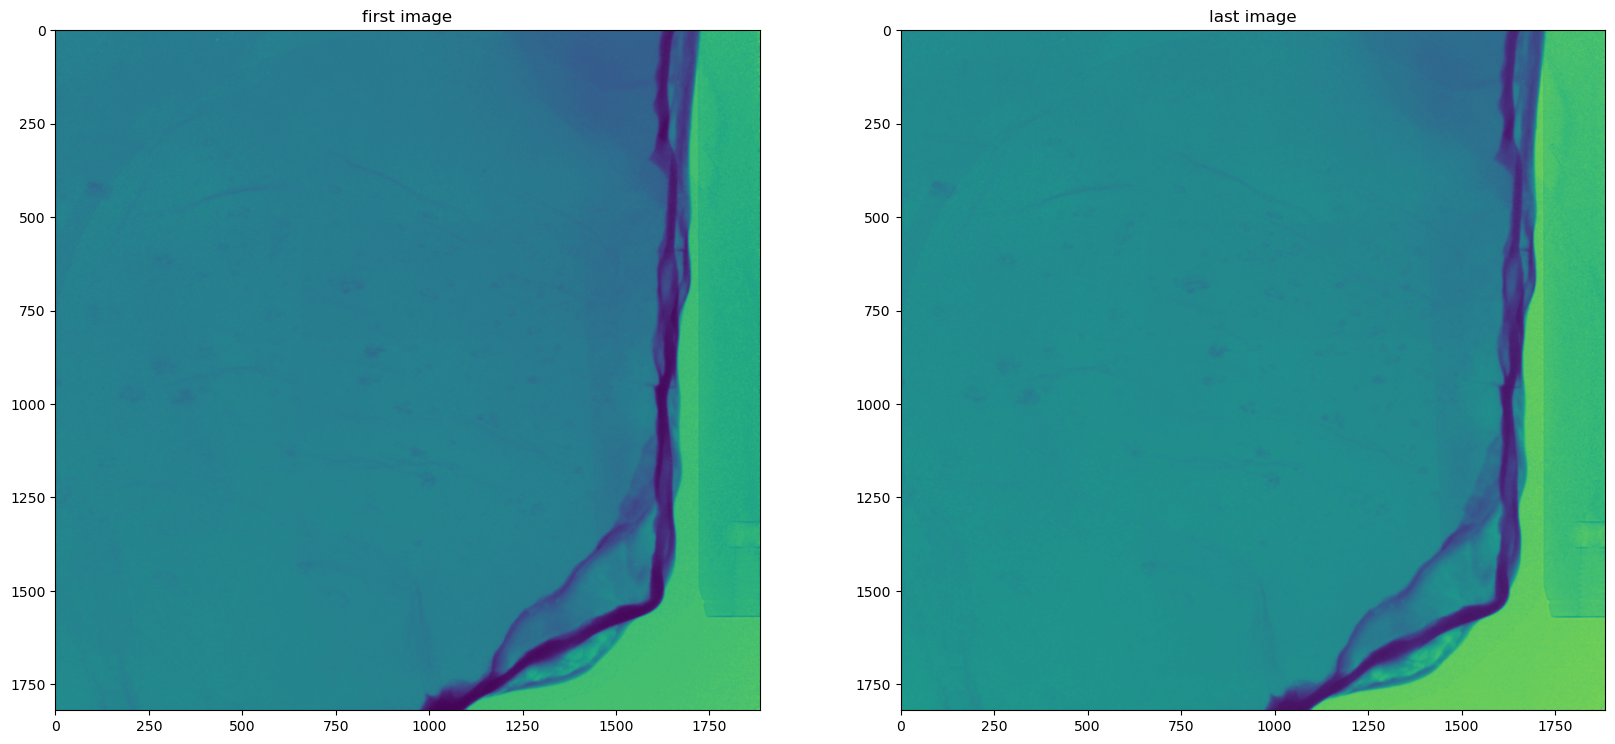

In [76]:
# img_min = np.min(unreg_dict[name_pattern[0]], axis=0)

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(unreg_dict[ref_name][0])
ax[0].set_title('first image')

ax[1].imshow(unreg_dict[ref_name][-1])
ax[1].set_title('last image')

# ax[2].imshow(img_min)
# ax[2].set_title('np.min')

In [77]:
###################### need to change start
crop = False
# crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 100
crop_right = -1
crop_top = 600
crop_bottom = -200
###################### need to change end
# proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
# ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
# dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
first_crop = rocku.crop(unreg_dict[ref_name][0], crop_left, crop_right, crop_top, crop_bottom, crop)
last_crop = rocku.crop(unreg_dict[ref_name][-1], crop_left, crop_right, crop_top, crop_bottom, crop)
if crop:
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(first_crop)
    ax[0].set_title('first image')

    ax[1].imshow(last_crop)
    ax[1].set_title('last image')

In [78]:
for ea_pa in unreg_dict.keys():
    unreg_dict[ea_pa] = rocku.crop(unreg_dict[ea_pa], crop_left, crop_right, crop_top, crop_bottom, crop)
trans_algo_dict = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

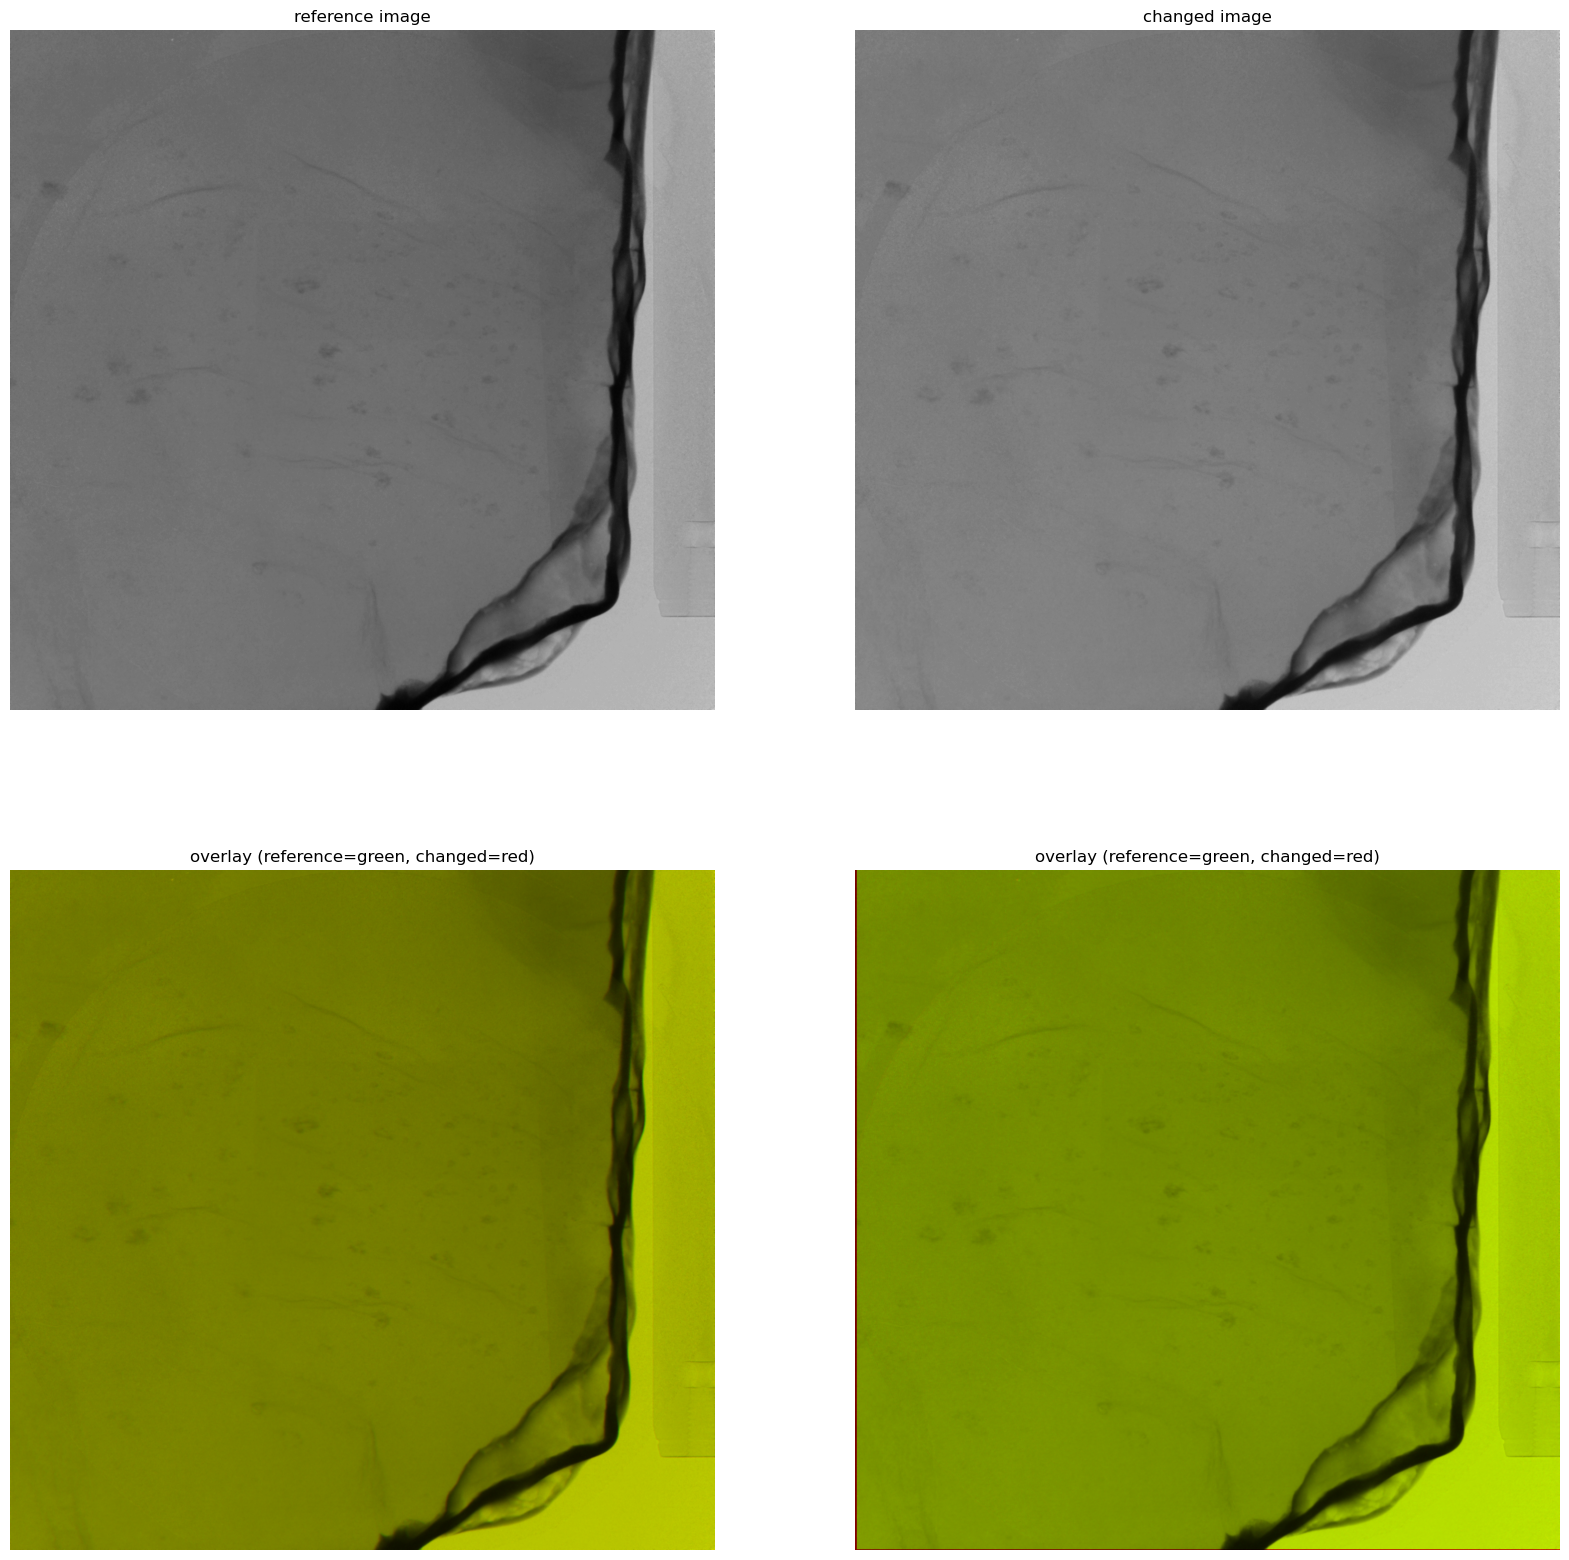

In [79]:
trans_algo = "SCALED_ROTATION"
#########################
#load reference and "moved" image
ref = unreg_dict[ref_name][0]
mov = unreg_dict[ref_name][-1]
#########################
sr = StackReg(trans_algo_dict[trans_algo])
reg = sr.register_transform(ref, mov)
reg = reg.clip(min=0)
after_reg = rocku.composite_images([ref, reg])
before_reg = rocku.composite_images([ref, mov])

f, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0][0].imshow(ref, cmap='gray')
ax[0][0].set_title('reference image')
ax[0][0].axis('off')

ax[0][1].imshow(mov, cmap='gray')
ax[0][1].set_title('changed image')
ax[0][1].axis('off')

ax[1][0].imshow(before_reg)
ax[1][0].set_title('overlay (reference=green, changed=red)')
ax[1][0].axis('off');

ax[1][1].imshow(after_reg)
ax[1][1].set_title('overlay (reference=green, changed=red)')
ax[1][1].axis('off');

In [80]:
# reference = 'previous'
reference = 'first'
###############################################
reg_dict = {}
sr = StackReg(trans_algo_dict[trans_algo])
print("Registration using '{}'".format(ref_name))
tmats = sr.register_stack(unreg_dict[ref_name], reference=reference, progress_callback=rocku.show_progress)
for ee in unreg_dict.keys():
    print("Apply transform to {}".format(ee))
    reg_dict[ee] = sr.transform_stack(unreg_dict[ee], tmats=tmats)

Registration using 'TI_ACL'
Registering 1 of 1 images
Apply transform to TI_ACL
Apply transform to DFI_ACL
Apply transform to DPC_ACL


In [81]:
reg_dict["AI_ACL"] = 1 - reg_dict["TI_ACL"]
# reg_dict["AI_ACL"] = reg_dict["AI_ACL"].clip(max=10)
reg_dict["DFI_over_AI_ACL"] = np.true_divide(reg_dict["DFI_ACL"], reg_dict["AI_ACL"])
# reg_dict["DFI_over_AI_ACL"] = reg_dict["DFI_over_AI_ACL"].clip(min=0, max=5)

/tmp/ipykernel_1409716/2168198323.py:3: RuntimeWarning: divide by zero encountered in divide
  reg_dict["DFI_over_AI_ACL"] = np.true_divide(reg_dict["DFI_ACL"], reg_dict["AI_ACL"])


# Save files

In [82]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/analysis/" + sample_name + "_" + trans_algo# + '_test'
if not os.path.exists(save_to):
    os.mkdir(save_to)
print("Saving to '{}' ...".format(save_to))
for each in name_pattern:
    for i, e_name in tqdm(enumerate(fname_dict_out[each])):
        fname = save_to + "/" + e_name + ".tiff"
        img_pl = Image.fromarray(reg_dict[each][i])
        img_pl.save(fname)

Saving to '/HFIR/CG1D/IPTS-33799/shared/analysis/2025_02_27_TopL4_SCALED_ROTATION' ...


2it [00:00, 27.23it/s]
2it [00:00, 29.34it/s]
2it [00:00, 29.92it/s]
2it [00:00, 30.00it/s]
2it [00:00, 23.25it/s]


(-0.5, 1884.5, 1819.5, -0.5)

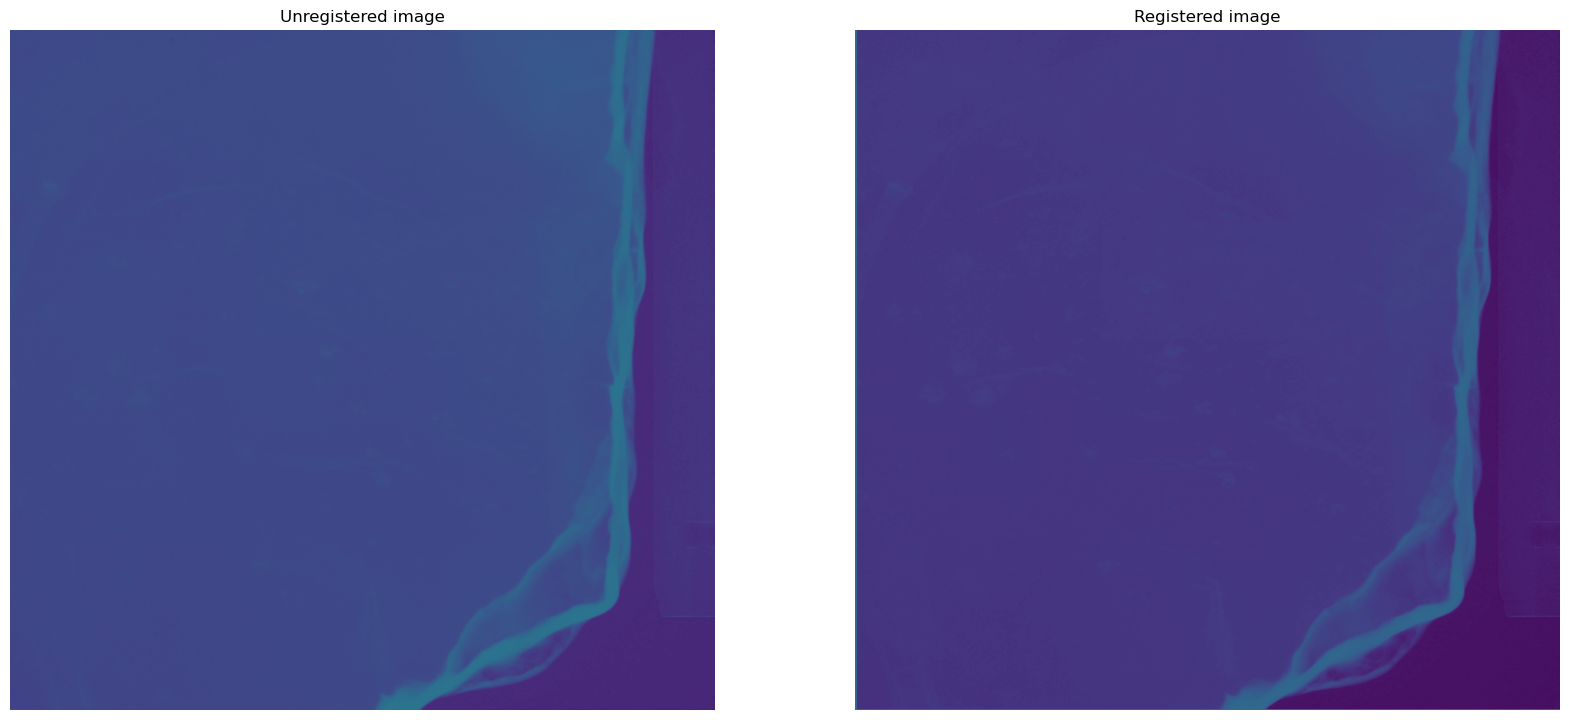

In [83]:
img_idx = -1
img_name = name_pattern[3]
#########################
f, ax = plt.subplots(1, 2, figsize=(20, 9))
check_reg =  rocku.composite_images([reg_dict[img_name][0], reg_dict[img_name][img_idx]])

ax[0].imshow(reg_dict[img_name][0], vmax=3)
ax[0].set_title('Unregistered image')
ax[0].axis('off')

ax[1].imshow(reg_dict[img_name][img_idx], vmax=3)
ax[1].set_title('Registered image')
ax[1].axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16107460549673633..1.0].


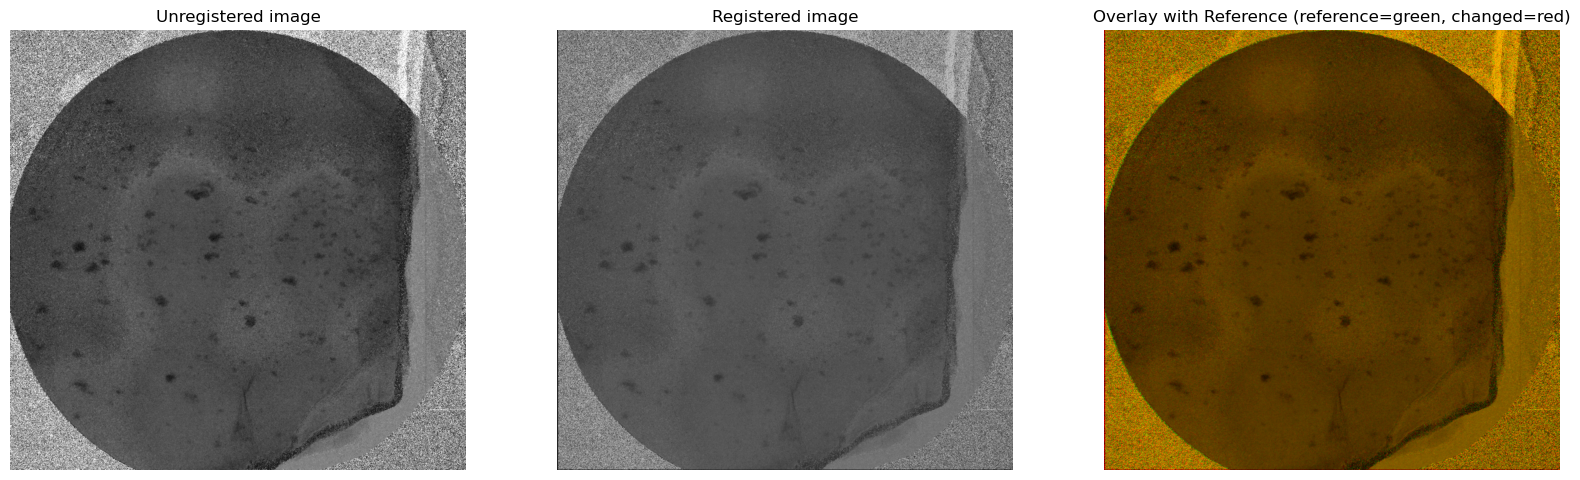

In [84]:
img_idx = -1
img_name = name_pattern[1]
#########################
f, ax = plt.subplots(1, 3, figsize=(20, 9))
check_reg = rocku.composite_images([reg_dict[img_name][0], reg_dict[img_name][img_idx]])

ax[0].imshow(unreg_dict[img_name][img_idx], cmap='gray')
ax[0].set_title('Unregistered image')
ax[0].axis('off')

ax[1].imshow(reg_dict[img_name][img_idx], cmap='gray')
ax[1].set_title('Registered image')
ax[1].axis('off')

ax[2].imshow(check_reg)
ax[2].set_title('Overlay with Reference (reference=green, changed=red)')
ax[2].axis('off');